In [1]:
import csv
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# indexes 0-based/1-based:
#           0/1     1/2  2/3     3/4   4/5              5/6          6/7
# format is station,date,measure,value,measurement flag,quality flag,source flag

In [3]:
stations = {}

with open('2019_TMAX.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        if line[5] != '':
            continue  # skip quality problems
        value = int(line[3]) / 10
        stations.setdefault(line[0], {}).setdefault('maxes', []).append(value)

with open('2019_TMIN.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        if line[5] != '':
            continue  # skip quality problems
        value = int(line[3]) / 10
        stations.setdefault(line[0], {}).setdefault('mins', []).append(value)

In [4]:
len(stations)

13946

In [5]:
min_days = 350
low_data = [station for station, data in stations.items()
            if len(data.get('maxes', [])) < min_days or
               len(data.get('mins', [])) < min_days]

In [6]:
len(low_data)

5555

In [7]:
for station in low_data:
    del stations[station]

In [8]:
len(stations)

8391

In [9]:
# original method (always within):
# penalize when min < cold and when hot < max
cold, hot = 0, 27  # 32 F, 80.6 F

scores = []
for station, data in stations.items():
    heat = [(temp - hot)**2 if temp > hot else 0
            for temp in data['maxes']]
    heat = (sum(heat) / len(heat))**0.5
    cool = [(temp - cold)**2 if temp < cold else 0
            for temp in data['mins']]
    cool = (sum(cool) / len(cool))**0.5
    scores.append([station, heat, cool, heat + cool])

In [9]:
# new method (range within):
# penalize when min < cold and when hot < max
cold, hot = 5, 15  # 41 F, 59 F

scores = []
for station, data in stations.items():
    # Max temp is too cold:
    cold = [(temp - cold)**2 if temp < cold else 0
            for temp in data['maxes']]
    cold = (sum(cold) / len(cold))**0.5
    # Min temp is too hot:
    heat = [(temp - hot)**2 if temp > hot else 0
            for temp in data['mins']]
    heat = (sum(heat) / len(heat))**0.5
    scores.append([station, heat, cold, heat + cold])

In [10]:
len(scores)

8391

In [11]:
scores.sort(key=lambda line: line[3])

In [12]:
scores[:10]

[['CA001034600', 0.0, 0.0, 0.0],
 ['CA001035940', 0.0, 0.0, 0.0],
 ['CA001063461', 0.0, 0.0, 0.0],
 ['SF000068994', 0.0, 0.0, 0.0],
 ['USC00043578', 0.0, 0.0, 0.0],
 ['USC00043824', 0.0, 0.0, 0.0],
 ['USC00350145', 0.0, 0.0, 0.0],
 ['USC00351058', 0.0, 0.0, 0.0],
 ['USC00352374', 0.0, 0.0, 0.0],
 ['USC00355055', 0.0, 0.0, 0.0]]

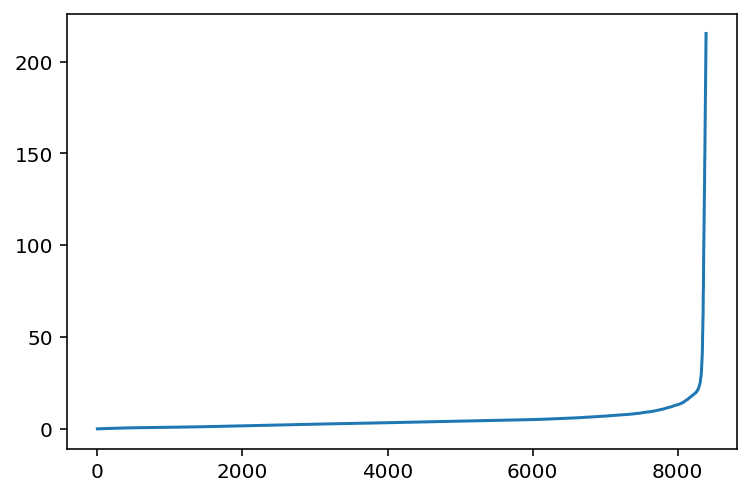

In [13]:
# total
plt.plot([line[3] for line in scores])

In [14]:
# this makes it seem like many places are habitable!

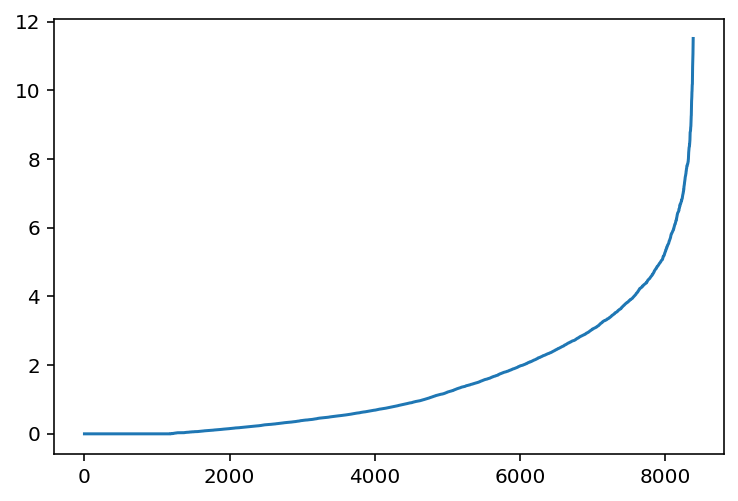

In [15]:
# heat
scores.sort(key=lambda line: line[1])
plt.plot([line[1] for line in scores])

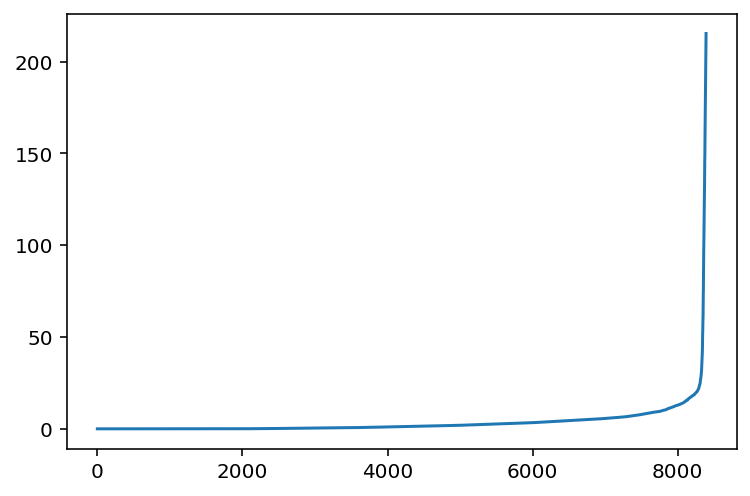

In [16]:
# cold
scores.sort(key=lambda line: line[2])
plt.plot([line[2] for line in scores])

In [17]:
# now it looks like there's more violation for heat! hmm!

In [18]:
locations = {}
with open('ghcnd-stations.txt') as f:
    for line in f:
        line = line.split()
        locations[line[0]] = [float(line[1]), float(line[2]), ' '.join(line[4:])]

In [19]:
results = []
for line in scores:
    if line[0] not in locations:
        continue
    results.append(line + locations[line[0]])

In [20]:
results[0]

['CA001034600', 0.0, 0.0, 0.0, 49.1167, -125.9167, 'BC LENNARD ISLAND']

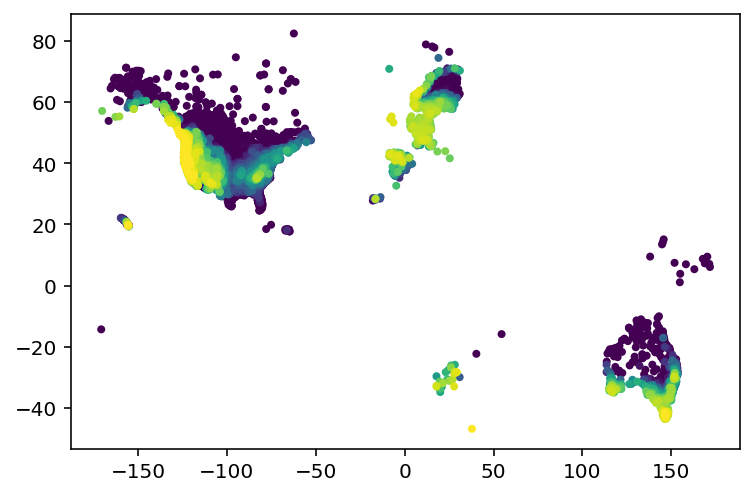

In [21]:
results.sort(key=lambda line: -line[3])  # draw good places last
plt.scatter([line[5] for line in results],
            [line[4] for line in results],
            c=[5 - line[3] if line[3] < 5 else 0 for line in results],
            marker='.')

In [112]:
# looking interesting! missing a lot of places though

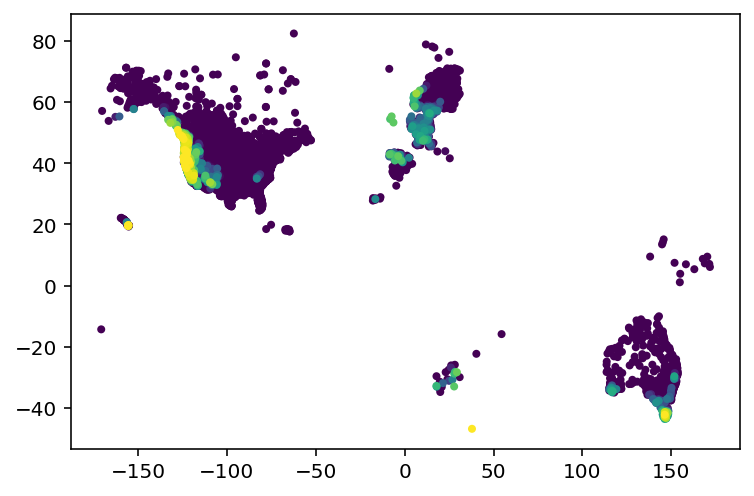

In [23]:
results.sort(key=lambda line: -line[3])  # draw good places last
plt.scatter([line[5] for line in results],
            [line[4] for line in results],
            c=[1 - line[3] if line[3] < 1 else 0 for line in results],
            marker='.')

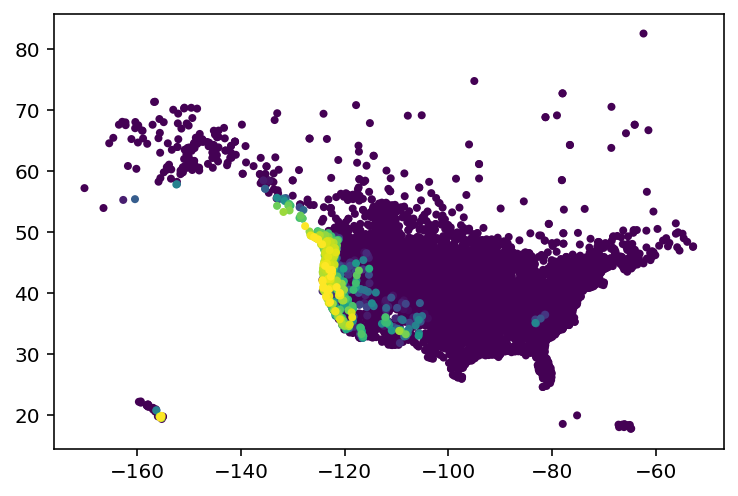

In [25]:
# just the US
results.sort(key=lambda line: -line[3])  # draw good places last
r = [line for line in results if line[5] < -40 and line[4] > 0]
plt.scatter([line[5] for line in r],
            [line[4] for line in r],
            c=[1 - line[3] if line[3] < 1 else 0 for line in r],
            marker='.')

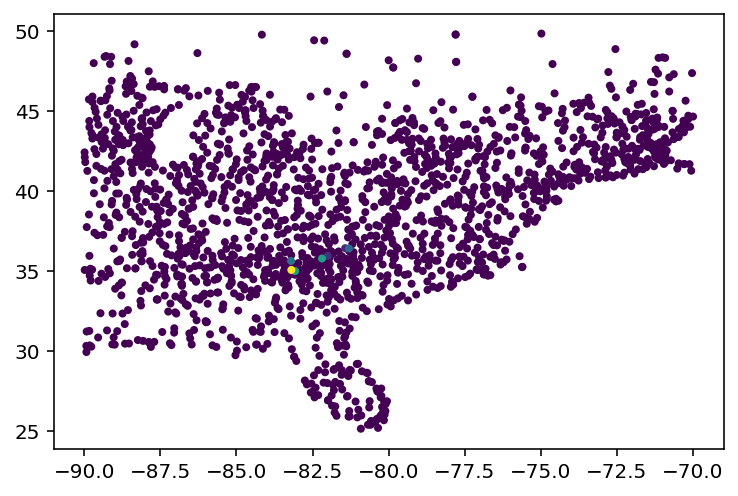

In [26]:
# closer in yet...
results.sort(key=lambda line: -line[3])  # draw good places last
r = [line for line in results if -90 < line[5] < -70 and 50 > line[4] > 25]
plt.scatter([line[5] for line in r],
            [line[4] for line in r],
            c=[1 - line[3] if line[3] < 1 else 0 for line in r],
            marker='.')

In [28]:
r[-3:]

[['USC00384581',
  0.751910807884618,
  0.0,
  0.751910807884618,
  34.9858,
  -83.0711,
  'SC JOCASSEE 8 WNW'],
 ['USR0000NBUS',
  0.5984225839998822,
  0.14583132354891398,
  0.7442539075487962,
  35.7694,
  -82.1917,
  'NC BUSICK NORTH CAROLINA'],
 ['USC00314055',
  0.4040547908051614,
  0.13718343814593412,
  0.5412382289510955,
  35.0564,
  -83.1983,
  'NC HIGHLANDS HCN']]